# Title : Ventilator pressure prediction for estimating the airway pressure in the respiratory circuit during the breath

### What is a Ventilator?

A ventilator is a machine that helps people breathe (ventilate).These machines are often used in hospitals as life support for patients who have difficulty breathing or who have lost all ability to breathe on their own. Mechanical ventilation may be either invasive or noninvasive (e.g. using a tight-fitting external mask).Invasive modes require the insertion of internal tubes/devices through endotracheal intubation or tracheostomy.

### When Are Ventilators Used?

Many diseases and other factors can affect lung function and cause difficulty breathing to the point that a person may need a ventilator to stabilize their condition.

Examples include:-
- Respiratory infections like pneumonia, influenza (flu) and coronavirus (COVID-19)
- Lung diseases like asthma, COPD (chronic obstructive pulmonary disease), cystic fibrosis and lung cancer
- Acute respiratory distress syndrome (ARDS)
- Damage to the nerves and/or muscles involved in breathing (can be caused by upper spinal cord injuries, polio, amyotrophic lateral sclerosis, myasthenia gravis, etc.)
- Brain injury
- Stroke
- Drug overdose

Patients who can’t breathe on their own at all also use ventilators while undergoing treatment for the underlying condition(s) that caused respiratory failure or respiratory arrest. Long-term ventilator care may be needed if a patient cannot regain the ability to breathe independently.

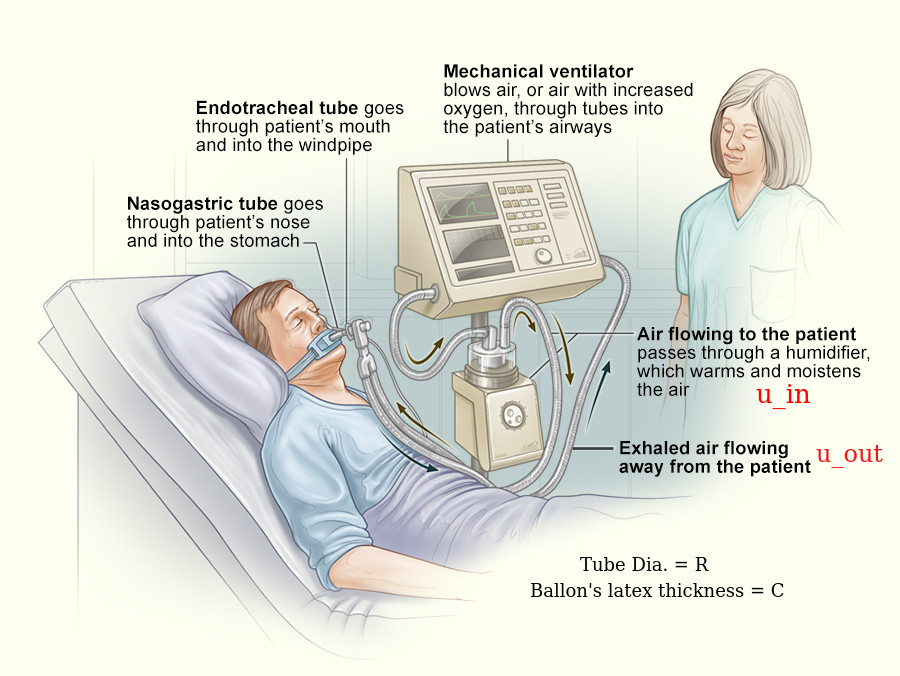

### How does a ventilator work?

A ventilator moves air into and out of the lungs (oxygen in and carbon dioxide out). It can be inserted through the mouth or nose, and down the trachea, or through a surgical opening, via tracheostomy. Depending on the patient’s medical condition, they may be able to use a respiratory mask in lieu of the breathing tubes. This is known as non-invasive mechanical ventilation.

The amount of oxygen the patient receives can be controlled through a monitor connected to the ventilator. If the patient’s condition is particularly delicate, the monitor will be set up to send an alarm to the caregiver indicating an increase in air pressure.

The machine works by bringing oxygen to the lungs and taking carbon dioxide out of the lungs. This allows a patient who has trouble breathing to receive the proper amount of oxygen. It also helps the patient’s body to heal, since it eliminates the extra energy of labored breathing.

p1.svg

# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored
from IPython import display

import warnings

warnings.filterwarnings('ignore')

In [ ]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [ ]:
import joblib
import gc

### Files

- train.csv - the training set
- test.csv - the test set

## Data Description
- id - globally-unique time step identifier across an entire file
- breath_id - globally-unique time step for breaths
- R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
- C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
- time_step - the actual time stamp.
- u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
- u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
- pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.(Target)

# Data Preprocessing

In [ ]:
data = pd.read_csv('Data/train_folds_12.csv')
#test_data = pd.read_csv('/content/drive/MyDrive/MY_PROJECT/Data/test.csv')

In [ ]:
data.drop('kfold', axis=1, inplace = True)

In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
print(f"Training Dataset Shape: {colored(data.shape, 'blue')}")

In [ ]:
data.memory_usage(deep=True)

In [ ]:
# downcasting data to save memory

data[["id","breath_id", "R","C", "u_out"]] = data[["id","breath_id", "R","C", "u_out"]].apply(pd.to_numeric, downcast="unsigned")

data[["time_step", "u_in", "pressure"]] = data[["time_step", "u_in", "pressure"]].apply(pd.to_numeric, downcast="float")

data.info()

In [ ]:
data.memory_usage(deep=True)

In [ ]:
# Columnwise Unique value

for col in data.columns:
    print(col + ":" + colored(str(len(data[col].unique())), 'blue'))


In [ ]:
data.isnull().sum()

In [ ]:
# distribution plot

def plot_distribution(x, title):
    
    """
    Function to obtain the distribution plot of given data.
    
    params: x(string)     : Name of the Column for the Plot.
            title(string) : Title of the Plot
    """
    sns.displot(data, x = x, kind="kde", bw_adjust=2)
    
    plt.title(title, fontsize = 12)
    plt.show()

In [ ]:
plot_list = [("R", "Lung Airway Restricted"),
             ("C", "Lung Compliance"),
             ("u_in", "Control input for the inspiratory solenoid"),
             ("u_out", "Control input for the exploratory solenoid valve"),
             ("pressure", "Airway pressure")
            ]

In [ ]:
for column, title in plot_list:
    plot_distribution(x = column, title = title)

In [ ]:
# count of R and C in data

fig, ax = plt.subplots(figsize = (14, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=data)
plt.title('Counts of R ');
plt.subplot(2, 2, 2)
sns.countplot(x='C', data=data)
plt.title('Counts of C ');


In [ ]:
data['R'].value_counts()

In [ ]:
#for train set

pair_rc = data.groupby(["R", "C"]).size().reset_index(name="Counts")
pair_rc["R"] = pair_rc[["R","C"]].apply(lambda cols: (cols[0],cols[1]),axis=1)
pair_rc.drop("C",axis=1,inplace=True)
pair_rc.rename(columns={'R':'R-C pair'},inplace=True)
plt.figure(figsize=(15,10))
sns.barplot(x="R-C pair",y="Counts",data=pair_rc);
plt.title("Counts of R-C pairs ");

In [ ]:
def show_correlogram(df):
    plt.figure(figsize=(20,10), dpi= 80)
    sns.heatmap(
        df.corr(), xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, cmap='coolwarm', center=0, annot=True, cbar=False
    )
    plt.title('Correlogram between features', fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

In [ ]:
show_correlogram(data)

In [ ]:
for i in range(1,6,1):
    one_breath = data[data["breath_id"]==i]

    plt.figure(figsize=(8,6));
    sns.lineplot(x = 'id',y='pressure',data=one_breath[one_breath['u_out']==0],color='green',label='pressure inhale');
    sns.lineplot(x = 'id',y='pressure',data=one_breath[one_breath['u_out']==1],color='orange',label='pressure exhale');
    sns.lineplot(x = 'id',y='u_in',data=one_breath,color='blue',label='valve position')
    plt.title(f"Variation of Pressure and Input valve position during breath {i}");
    plt.legend();

In [ ]:
# Plot of 10 breath_id
ten_breath = data[:800]

plt.figure(figsize=(20,6));
sns.lineplot(x = 'id',y='pressure',data=ten_breath[ten_breath['u_out']==0],color='green',label='pressure inhale- pressure till u_out =0');
sns.lineplot(x = 'id',y='pressure',data=ten_breath[ten_breath['u_out']==1],color='orange',label='pressure exhale-  pressure till u_out =1');
sns.lineplot(x = 'id',y='u_in',data=ten_breath,color='blue',label='valve position- u_in')
plt.title("Variation of Pressure and Input valve position during breath");
plt.legend();

In [ ]:
# Plot of 10 breath_id 
ten_breath = data[:800]

plt.figure(figsize=(20,6));
sns.lineplot(x = 'id',y='pressure',data=ten_breath,color='green',label='pressure');
sns.lineplot(x = 'id',y='u_in',data=ten_breath,color='blue',label='valve position- u_in')
plt.title("Variation of Pressure and Input valve position during breath");
plt.legend();

## Adding some features

In [ ]:
def add_features(df):

  df['area'] = df.u_in *df.u_out
  df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
  df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
  df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
  df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
  df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
  df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
  df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
  df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
  df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
  df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
  df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
  df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
  df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
  df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
  df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
  df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
  df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
  df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
  df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
  df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
  df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
  df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
  df['R_'] = df['R'].astype(str)
  df['C_'] = df['C'].astype(str)
  df['R__C'] = df["R_"].astype(str) + '__' + df["C_"].astype(str)

  return df


In [ ]:
add_features(data)

In [ ]:
data.info()

In [ ]:
data.isnull().sum()

In [ ]:
data = data.fillna(0)

In [ ]:
# Plot for 1 breath_id 

df1 = data[:80]

df1['u_in_lag1'].plot()
df1['u_in_lag2'].plot()
df1['u_in_lag3'].plot()
df1['u_in_lag_back1'].plot()
df1['u_in_lag_back2'].plot()
df1['u_in_lag_back3'].plot()
plt.legend()



In [ ]:
df1['u_in'].plot()
df1['breath_id__u_in__diffmax'].plot()
df1['breath_id__u_in__diffmean'].plot()
plt.legend()

del df1
gc.collect()

In [ ]:
df_categorical = data.select_dtypes(include=[np.object])

In [ ]:
df_categorical.head()

In [ ]:
# OneHotEncoding Categorical data 
ohe = OneHotEncoder() 
ohe.fit(df_categorical) 
df_ohe = ohe.transform(df_categorical).toarray() # Perform one-hot encoding
df_ohe = pd.DataFrame(df_ohe)


In [ ]:
final_df = data.join(df_ohe)

del df_categorical
del df_ohe

In [ ]:
final_df.shape

In [ ]:
final_df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]] = final_df[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]].apply(pd.to_numeric, downcast="unsigned")

In [ ]:
final_df.info()

# Train Test Split

In [ ]:
X = final_df.drop(['pressure',"R_",'C_','R__C'], axis=1)
y = final_df.pressure

In [ ]:
# To save memory Deleted the saved DataFrames
del data
# del final_df

gc.collect()


In [ ]:
# Scaling the data using RobustScaler()
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
# X_test = scaler.fit_transform(x_test)

In [ ]:
del final_df

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size = 0.2, random_state = 42 )

# Training Model

In [ ]:
# Evaluation metrics function 

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100



## Linear Regression

In [ ]:
LR_model = LinearRegression()

In [ ]:
# LR_model.fit(X_train, y_train)

In [ ]:
# # saving our model # model - RFR = RandomForestRegressor(n_estimators=100, random_state =42 )
# # filename- LR_model_jlib
# joblib.dump(LR_model, 'LR_model_jlib')

In [ ]:
# # load the model from disk
loaded_LR_model = joblib.load('LR_model_jlib(1)')


In [ ]:
y_prediction =  loaded_LR_model.predict(X_test)

In [ ]:
mse_LR = mean_squared_error(y_test, y_prediction)
mae_LR = mean_absolute_error(y_test, y_prediction)
LR_r2 = r2_score(y_test, y_prediction)
LR_MAPE = mape(y_test, y_prediction)
print('Mean Squared Error :',mse_LR)
print('Mean Absolute Error :', mae_LR)
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, y_prediction))


In [ ]:
resultsLR = pd.DataFrame({'Mean Squared Error':mse_LR,
                          'Mean Absolute Error':mae_LR,
                          'R Squared Score': LR_r2,
                          'MAPE Score':LR_MAPE }
                           ,index=['Linear Regressor'])

resultsLR

In [ ]:
plt.scatter(x = [range(0,80)], y = y_prediction[:80], cmap = 'RdPu')
plt.scatter(x = [range(0,80)], y = y_test[:80])
plt.show()

### XGBoost

In [ ]:
from xgboost import XGBRegressor

In [ ]:
# XGB_model = XGBRegressor(n_estimators=30000, learning_rate=0.15, max_depth=10, min_child_weight=5, tree_method='gpu_hist')

# XGB_model.fit(X_train, y_train)

In [ ]:
# joblib.dump(XGB_model, 'XGB_model_jlib')

In [ ]:
# # load the model from disk
loaded_XGB_model = joblib.load('XGB_model_jlib')


In [ ]:
xgb_y_prediction = loaded_XGB_model.predict(X_test)

In [ ]:
mse_XGB = mean_squared_error(y_test, xgb_y_prediction)
mae_XGB = mean_absolute_error(y_test, xgb_y_prediction)
XGB_r2 = r2_score(y_test, xgb_y_prediction)
XGB_MAPE = mape(y_test, xgb_y_prediction)
print('Mean Squared Error :',mse_XGB)
print('Mean Absolute Error :', mae_XGB)
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, xgb_y_prediction))

In [ ]:
resultsXGB = pd.DataFrame({'Mean Squared Error':mse_XGB,
                          'Mean Absolute Error':mae_XGB,
                          'R Squared Score': XGB_r2,
                          'MAPE Score':XGB_MAPE }
                           ,index=['XGBoost Regressor'])

results2 = pd.concat([resultsXGB,resultsLR])
results2
# resultsXGB

## Light Boost GBM

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
# LGBMR_model = LGBMRegressor(n_estimators = 300, tree_method='gpu_hist')

In [ ]:
# LGBMR_model.fit(X_train, y_train)

In [ ]:
# # load the model from disk
loaded_lgbr_model = joblib.load('LGBMR_model_jlib')


In [ ]:
lgbm_y_prediction =  loaded_lgbr_model.predict(X_test)

In [ ]:
mse_LGBR = mean_squared_error(y_test, lgbm_y_prediction)
mae_LGBR = mean_absolute_error(y_test, lgbm_y_prediction)
LGBR_r2 = r2_score(y_test, lgbm_y_prediction)
LGBR_MAPE = mape(y_test, lgbm_y_prediction)
print('Mean Squared Error :',mse_LGBR)
print('Mean Absolute Error :', mae_LGBR)
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, lgbm_y_prediction))

In [ ]:
resultsLGBR = pd.DataFrame({'Mean Squared Error':mse_LGBR,
                          'Mean Absolute Error':mae_LGBR,
                          'R Squared Score': LGBR_r2,
                          'MAPE Score':LGBR_MAPE }
                           ,index=['Light GBM Regressor'])

results3 = pd.concat([resultsLGBR,resultsLR])
results3
# resultsLGBR

## SkForecast XGB Regressor Model

In [ ]:
!pip install skforecast

In [ ]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [ ]:
# Create forecaster
# ==================================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(n_estimator=5000, max_depth=10, learning_rate=0.15,
                                         random_state=123 ,tree_method='gpu_hist'),
                lags = 10
                )

In [ ]:
# forecaster.fit(y=y_train,exog=X_train)

In [ ]:
step = y_test.shape[0]

In [ ]:
# # load the model from disk
loaded_skforecast_model = joblib.load('skforecast_model_jlib')

In [ ]:
# x_test = pd.DataFrame(X_test)

In [ ]:
# skforecast_prediction=loaded_skforecast_model.predict(steps=step,exog=x_test)

In [ ]:
mse_skforecast = mean_squared_error(y_test, skforecast_prediction)
mae_skforecast = mean_absolute_error(y_test, skforecast_prediction)
skforecast_r2 = r2_score(y_test, skforecast_prediction)
skforecast_MAPE = mape(y_test, skforecast_prediction)
print('Mean Squared Error :',mse_skforecast)
print('Mean Absolute Error :', mae_skforecast)
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, skforecast_prediction))

In [ ]:
results_skforecast = pd.DataFrame({'Mean Squared Error':mse_skforecast,
                          'Mean Absolute Error':mae_skforecast,
                          'R Squared Score': skforecast_r2,
                          'MAPE Score':skforecast_MAPE }
                           ,index=['skforecast XGB Regressor'])

results4 = pd.concat([results_skforecast,results3])
results4
# resultsLGBR

# TabNet Regressor Model

In [ ]:
# !pip install pytorch-tabnet

In [ ]:
X      = X.to_numpy()
y      = y.to_numpy().reshape(-1, 1)

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=8)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=8)


In [ ]:
print("X train shape: ", x_train.shape)
print("X validation shape: ", x_val.shape)
print("X test shape: ", x_test.shape)
print("Y train shape: ", y_train.shape)
print("Y validation shape: ", y_val.shape)
print("Y test shape: ", y_test.shape)


In [ ]:
regressor = TabNetRegressor(verbose=1,seed=42)

In [ ]:
regressor

In [ ]:
# regressor.fit(X_train=x_train, y_train=y_train,
#               eval_set=[(x_val, y_val)],
#               patience=30, max_epochs=200,
#               eval_metric=['mse'])

In [ ]:
# # load the model from disk
loaded_tabnet_model = joblib.load('TabNet_model_jlib')

In [ ]:
tabnet_prediction = regressor.predict(x_test)

In [ ]:
mse_tabnet = mean_squared_error(y_test, tabnet_prediction)
mae_tabnet = mean_absolute_error(y_test, tabnet_prediction)
tabnet_r2 = r2_score(y_test, tabnet_prediction)
tabnet_MAPE = mape(y_test, tabnet_prediction)
print('Mean Squared Error :',mse_tabnet)
print('Mean Absolute Error :', mae_tabnet)
print("Mean Absolute Percentage Error :", mean_absolute_percentage_error(y_test, tabnet_prediction))

In [ ]:
results_tabnet = pd.DataFrame({'Mean Squared Error':mse_tabnet,
                          'Mean Absolute Error':mae_tabnet,
                          'R Squared Score': tabnet_r2,
                          'MAPE Score':tabnet_MAPE }
                           ,index=['TabNet Regressor'])

results5 = pd.concat([results_tabnet,results4])
results5


# Comparing the results froim these 5 model we got minimum erors from XGBoost Regressor Model.
